In [9]:
import pandas as pd
from data_preprocessing import get_data_label_map
from models import load_model_and_data

import torch
import torch.nn.functional as F

In [38]:
def denormalize(tensor, mean, std):
    """
    Denormalize a tensor given the mean and standard deviation used for normalization.
    
    Args:
    - tensor (torch.Tensor): Input tensor to denormalize
    - mean (tuple): Mean values used for normalization
    - std (tuple): Standard deviation values used for normalization
    
    Returns:
    - torch.Tensor: Denormalized tensor
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

In [2]:
df = pd.read_csv('../results/splits_trained_on_fixed.csv')

label_map, inverse_label_map = get_data_label_map(df)

Lowest loss: 8.4638240878121e-06
True label: 28
Predicted label: 28


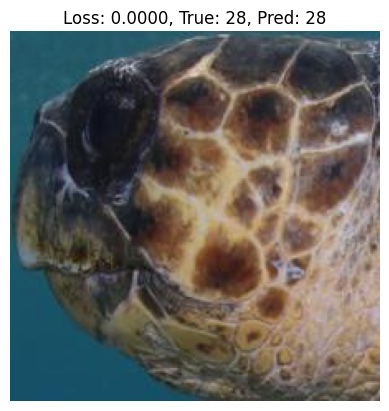

In [33]:
loaded = load_model_and_data('crossentropy_base_encounter.pth', 'crossentropy', 'encounter', label_map)

model = loaded['model']
test_loader = loaded['test_loader']

model.eval()

# Go through all test images and find the one with the lowest loss
lowest_loss = float('inf')
lowest_loss_image = None
lowest_loss_label = None
lowest_loss_prediction = None

device = next(model.parameters()).device  # Get the device the model is on

with torch.no_grad():  # No need to track gradients
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # Calculate loss for each image in the batch
        loss = F.cross_entropy(output, target, reduction='none')
        
        # Find the index of the image with the lowest loss in this batch
        batch_min_loss, batch_min_index = loss.min(0)
        
        # If this loss is lower than the current lowest, update all variables
        if batch_min_loss < lowest_loss:
            lowest_loss = batch_min_loss.item()
            lowest_loss_image = data[batch_min_index].cpu()  # Move back to CPU for easier handling
            lowest_loss_label = target[batch_min_index].item()
            lowest_loss_prediction = output[batch_min_index].argmax().item()

print(f"Lowest loss: {lowest_loss}")
print(f"True label: {lowest_loss_label}")
print(f"Predicted label: {lowest_loss_prediction}")

# If you want to display the image (assuming it's a regular image, not a spectrogram or something else)
import matplotlib.pyplot as plt

denormalized_lowest_loss_image = denormalize(lowest_loss_image, (0.3717, 0.4016, 0.3666), (0.1553, 0.1433, 0.1397))

plt.imshow(denormalized_lowest_loss_image.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C)
plt.title(f"Loss: {lowest_loss:.4f}, True: {lowest_loss_label}, Pred: {lowest_loss_prediction}")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


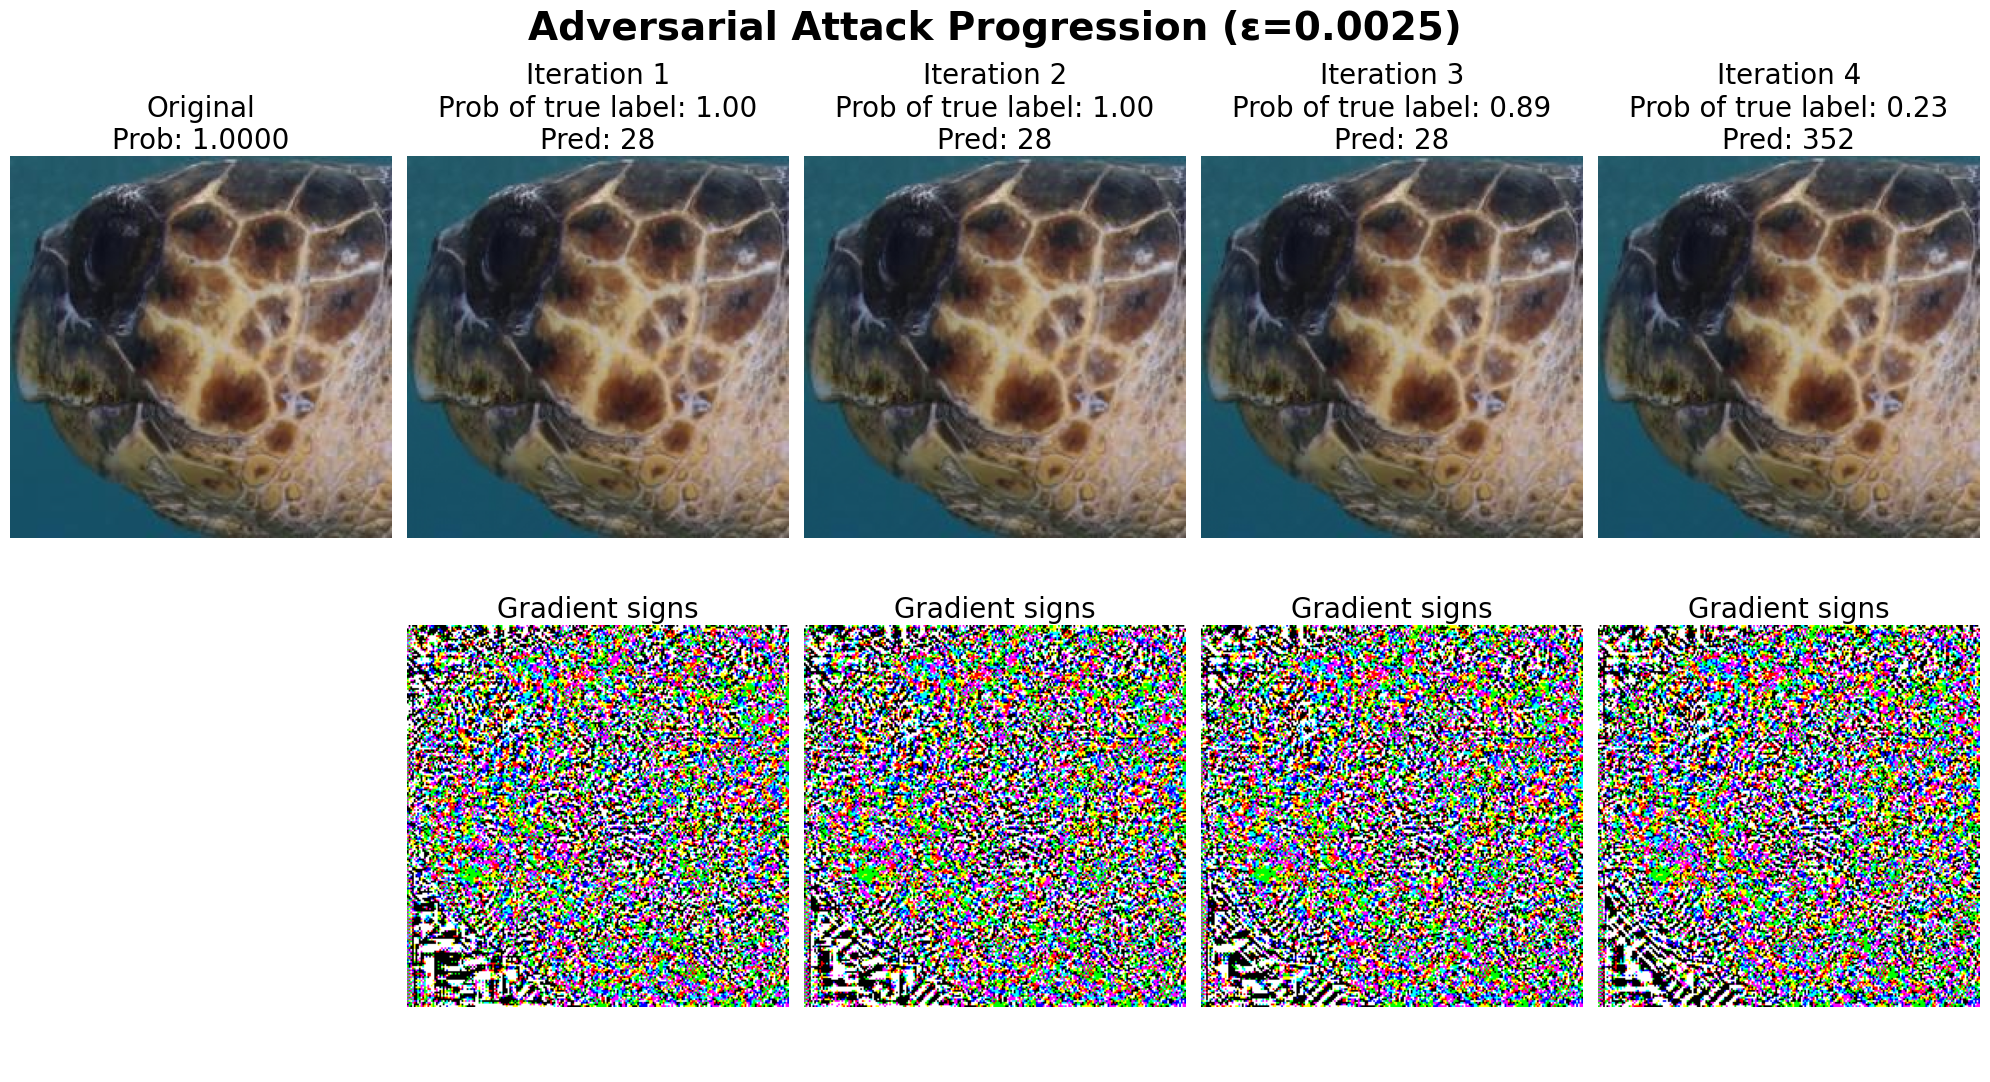

Original label: 28
Final prediction: 352
Final probability of true class: 0.2300


In [114]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return perturbed_image, sign_data_grad

def attack_and_visualize(model, original_image, true_label, epsilon, num_iterations):
    model.eval()
    
    image = original_image.unsqueeze(0).to(next(model.parameters()).device)
    image.requires_grad = True

    output = model(image)
    orig_pred = output.argmax(1).item()
    orig_prob = F.softmax(output, dim=1)[0, true_label].item()

    fig, axs = plt.subplots(2, num_iterations + 1, figsize=(20, 11))
    fig.suptitle(f'Adversarial Attack Progression (ε={epsilon})', fontsize=28, fontweight='bold')

    axs[0, 0].imshow(denormalize(original_image, (0.3717, 0.4016, 0.3666), (0.1553, 0.1433, 0.1397)).permute(1, 2, 0).cpu().numpy())
    axs[0, 0].set_title(f'Original\nProb: {orig_prob:.4f}', fontsize=20)
    axs[0, 0].axis('off')

    # Make the first plot in the second row blank
    axs[1, 0].axis('off')

    for i in range(num_iterations):
        model.zero_grad()
        
        output = model(image)
        loss = F.cross_entropy(output, torch.tensor([true_label]).to(image.device))
        
        loss.backward()
        
        data_grad = image.grad.data
        
        image, diff = fgsm_attack(image, epsilon, data_grad)
        image = image.detach_()
        diff = diff.detach_()
        image.requires_grad = True
        
        output = model(image)
        prob = F.softmax(output, dim=1)[0, true_label].item()
        pred = output.argmax(1).item()
        
        axs[0, i+1].imshow(denormalize(image, (0.3717, 0.4016, 0.3666), (0.1553, 0.1433, 0.1397)).squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        axs[0, i+1].set_title(f'Iteration {i+1}\nProb of true label: {prob:.2f}\nPred: {pred}', fontsize=20)
        axs[0, i+1].axis('off')
        
        # Calculate and display difference for all channels
        axs[1, i+1].imshow(diff.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axs[1, i+1].set_title(f'Gradient signs', fontsize=20)
        axs[1, i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

    return image.squeeze(0)

# Assuming we have the lowest_loss_image, lowest_loss_label from the previous code
epsilon = 0.0025  # You can adjust this
num_iterations = 4  # You can adjust this

# Perform the attack and visualize
final_perturbed_image = attack_and_visualize(model, lowest_loss_image, lowest_loss_label, epsilon, num_iterations)

# Final evaluation
model.eval()
with torch.no_grad():
    final_output = model(final_perturbed_image.unsqueeze(0).to(next(model.parameters()).device))
    final_prob = F.softmax(final_output, dim=1)[0, lowest_loss_label].item()
    final_pred = final_output.argmax(1).item()

print(f"Original label: {lowest_loss_label}")
print(f"Final prediction: {final_pred}")
print(f"Final probability of true class: {final_prob:.4f}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


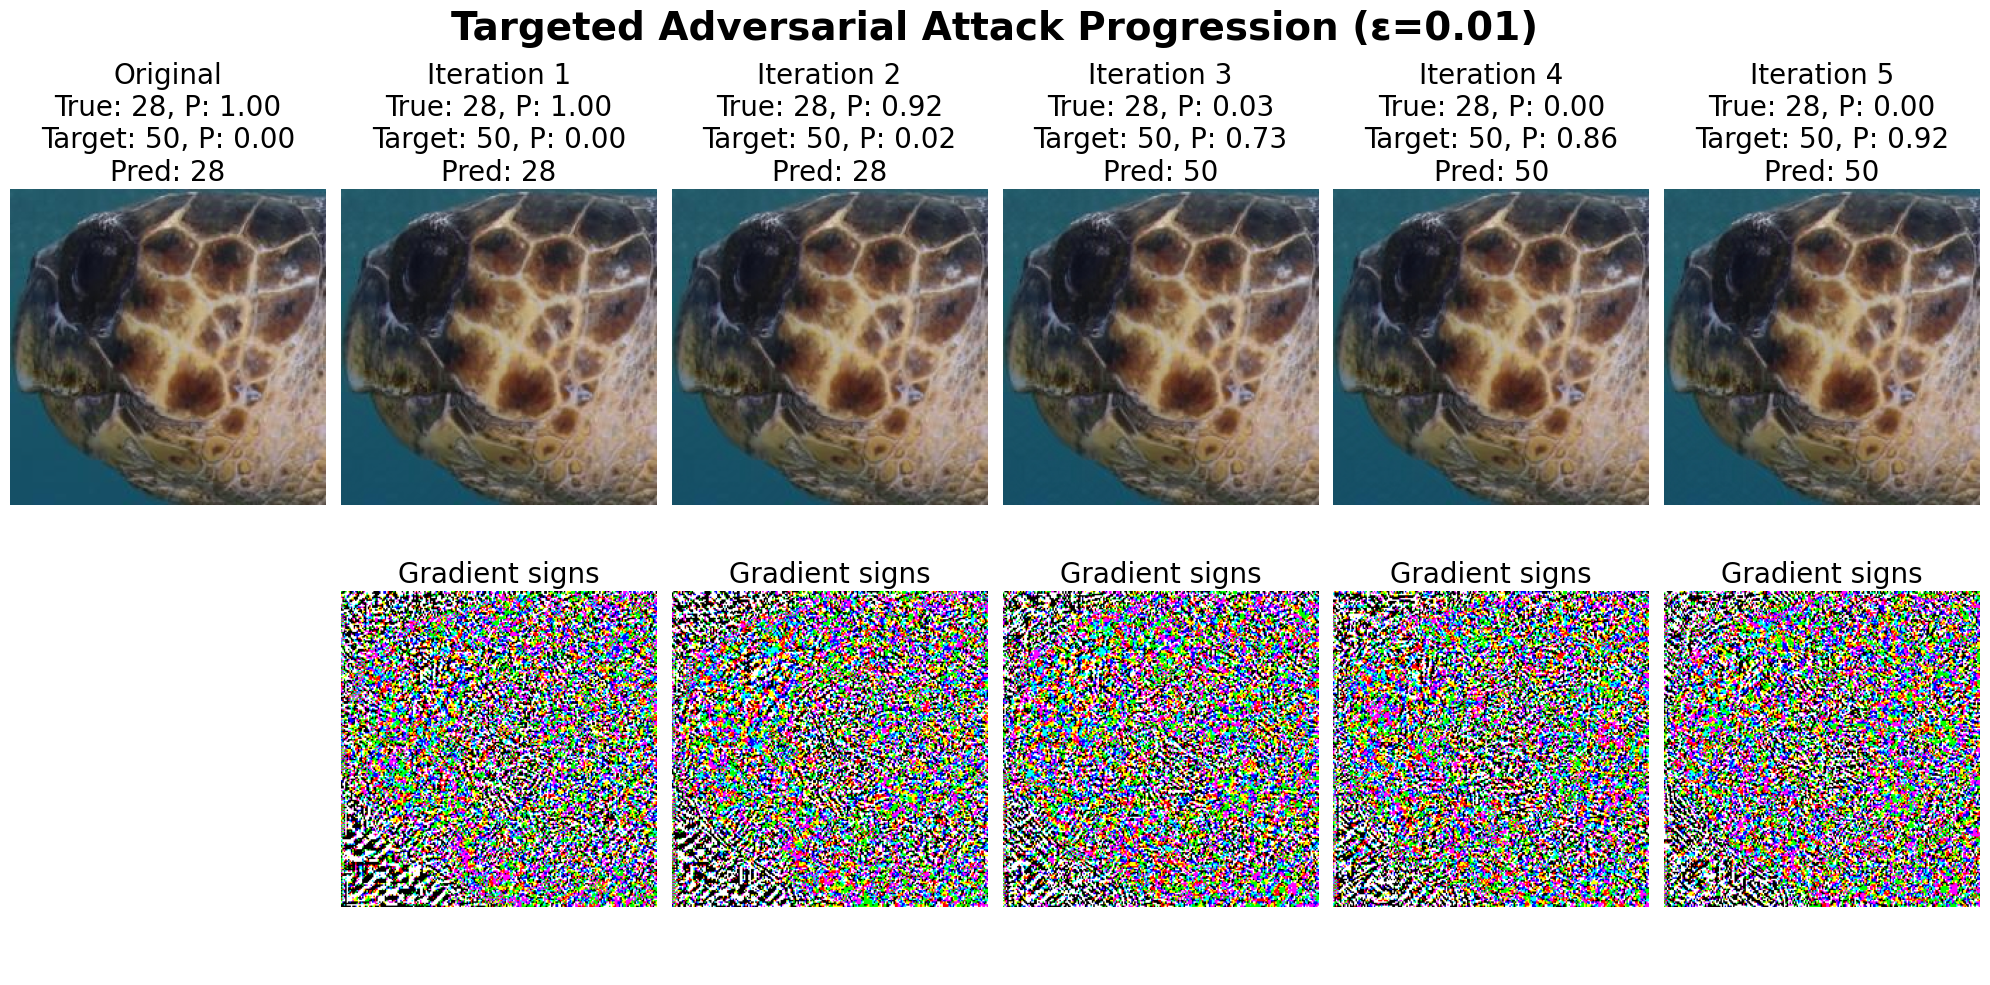

Original label: 28
Target label: 50
Final prediction: 50
Final probability of true class: 0.0000
Final probability of target class: 0.9171


In [115]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image - epsilon * sign_data_grad  # Note the minus sign for targeted attack
    return perturbed_image, sign_data_grad

def attack_and_visualize(model, original_image, true_label, target_label, epsilon, num_iterations):
    model.eval()
   
    image = original_image.clone().unsqueeze(0).to(next(model.parameters()).device)
    image.requires_grad = True
    
    output = model(image)
    orig_pred = output.argmax(1).item()
    orig_prob = F.softmax(output, dim=1)[0, true_label].item()
    target_prob = F.softmax(output, dim=1)[0, target_label].item()

    fig, axs = plt.subplots(2, num_iterations + 1, figsize=(20, 10))
    fig.suptitle(f'Targeted Adversarial Attack Progression (ε={epsilon})', fontsize=28, fontweight='bold')
    axs[0, 0].imshow(denormalize(original_image, (0.3717, 0.4016, 0.3666), (0.1553, 0.1433, 0.1397)).permute(1, 2, 0).cpu().numpy())
    axs[0, 0].set_title(f'Original\nTrue: {true_label}, P: {orig_prob:.2f}\nTarget: {target_label}, P: {target_prob:.2f}\nPred: {orig_pred}', fontsize=20)
    axs[0, 0].axis('off')
    
    axs[1, 0].axis('off')

    for i in range(num_iterations):
        model.zero_grad()
       
        output = model(image)
        # For targeted attack, we want to maximize the probability of the target class
        loss = -output[0, target_label]
       
        loss.backward()
       
        data_grad = image.grad.data
       
        image, diff = fgsm_attack(image, epsilon, data_grad)
        image = image.detach_()
        diff = diff.detach_()
        image.requires_grad = True
       
        with torch.no_grad():
            output = model(image)
            probs = F.softmax(output, dim=1)[0]
            true_prob = probs[true_label].item()
            target_prob = probs[target_label].item()
            pred = output.argmax(1).item()
       
        axs[0, i+1].imshow(denormalize(image.squeeze(0), (0.3717, 0.4016, 0.3666), (0.1553, 0.1433, 0.1397)).permute(1, 2, 0).cpu().detach().numpy())
        axs[0, i+1].set_title(f'Iteration {i+1}\nTrue: {true_label}, P: {true_prob:.2f}\nTarget: {target_label}, P: {target_prob:.2f}\nPred: {pred}', fontsize=20)
        axs[0, i+1].axis('off')
       
        axs[1, i+1].imshow(diff.squeeze(0).permute(1, 2, 0).cpu().numpy())
        axs[1, i+1].set_title(f'Gradient signs', fontsize=20)
        axs[1, i+1].axis('off')
   
    plt.tight_layout()
    plt.show()
    return image.squeeze(0)

# Assuming we have the model, lowest_loss_image, lowest_loss_label from the previous code
epsilon = 0.01  # Increased epsilon
num_iterations = 5  # Increased number of iterations
target_label = 50  # The label we want the model to predict

# Perform the attack and visualize
final_perturbed_image = attack_and_visualize(model, lowest_loss_image, lowest_loss_label, target_label, epsilon, num_iterations)

# Final evaluation
model.eval()
with torch.no_grad():
    final_output = model(final_perturbed_image.unsqueeze(0).to(next(model.parameters()).device))
    probs = F.softmax(final_output, dim=1)[0]
    final_true_prob = probs[lowest_loss_label].item()
    final_target_prob = probs[target_label].item()
    final_pred = final_output.argmax(1).item()

print(f"Original label: {lowest_loss_label}")
print(f"Target label: {target_label}")
print(f"Final prediction: {final_pred}")
print(f"Final probability of true class: {final_true_prob:.4f}")
print(f"Final probability of target class: {final_target_prob:.4f}")